In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import copy

## Logistic Regression - A method for binary classification.

Despite the fact that we typically use logistic regression for classification problems, it is indeed a regression model. If our target variable is a 0/1 binary variable, the continuous variable we aim to predict is the *probability* that the binary label is equal to 1. 


Recall that when we use linear regression to predict target variable $y$ conditional on feature vector $x$, we make the modelling assumption that there is a vector of parameters, $\beta$, such that 

$$y|x \sim N(\beta^Tx, \sigma^2)$$

That is, we assume y follows a normal distribution\* and try to find its mean.


For logistic regression, we make a similar assumption: For target variable $y$ and features $x$ we assume that 

$$ y|x \sim \text{Bin}(1, p(x))$$

That is, y follows a binomial distribution where the probability is determined by a function $p(x)$. We want to estimate what the function $p$ is. 

\* **Note that we don't assume all of the target variables in a dataset follow the same normal distribution. Rather the target for a single observation has it's own personal distribution which we want to find the mean of.**


The method we use to predict this probability bears a certain resemblance to how we fit a linear regression model, but has a couple of extra steps:

1. Firstly, when we're doing linear regression, we make a prediction by estimating a parameter vector $\beta$ and then computing $\beta^Tx$ for an input vector $x$. This allows us to predict any value between $-\infty \text{ and } \infty$, but if we're trying to predict a probability between 0 and 1, we need to do something different.

2. When we're training a linear regression model, we know what the target variable is for all of the variables in the training set during training. Conversely, when training a logistic regression model, we don't know what the probabilty for the target taking a certain value is - we only know the binary value that the target eventually took. 

To combat the issue of making predictions between 0 and 1, we use a *link function*. We still want to make our predictions using $\beta^Tx$, but we force the output to be in the right range ($[0,1]$) by passing $\beta^Tx$ through a function. The general idea is that we need to choose a function such that if $\beta^Tx$ is large and negative, we want to assign a probability of approximately 0, whereas if it's large and positive we want to assign a probability of approximately 1. A commonly used link function is the function is the function 

$$f(x) = \frac{1}{1 + \exp(-x)}$$

A quick plot of $f(x)$ shows that it exhibits the desired behaviour

In [2]:
X = np.linspace(-10,10, 10000)

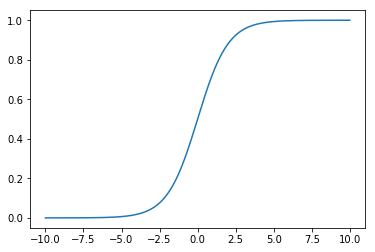

In [3]:
fx = [1/(1 + np.exp(-x)) for x in X]
plt.plot(X, fx)
plt.show() #We can see that the function is bounded below and above by 0 and 1, respectively.

**Now for the second problem**: For some regression problems you might be familiar with the idea of minimising the sum-of-squared errors of our predictions. That approach won't work here, because we don't know what the true probabilities are so we can't compare our predictions to them.

Instead we adopt the principle when training that the more confidently our model predicts, the more it should be penalised if it is subsequently wrong. For example, if our model says that the $P(Y = 1) = 0.95$ and it turns out that $Y = 0$, then it should be penalised more heavily than if it estimates $P(Y = 1) = 0.55$ (in which case it doesn't really know but has to pick one label or the other) when $Y = 0$


For a dataset $(y_1, x_1), ..., (y_n, x_n)$, (with $y_i \in \{0,1\}$ and $x_i$ a p-dimensional vector) we want to choose $\beta$ such that the following function is minimised:

$$L(\beta) = \sum_{i = 1}^n -(y_i \times \log(P(y_i = 1|x_i, \beta )) + (1 - y_i) \times \log(1 - P(y_i = 1|x_i, \beta )))$$

This loss function is known as the *logarithmic* or *cross-entropy loss*.

Unlike with linear regression there is no analytical solution to find the minimum of $L(\beta)$, so we have to adopt an iterative approximation scheme for finding the minimum. The details of the algorithm can be found online (for instance on page 121 of *The Elements of Statistical Learning*), but for the purposes of implementation it proceeds in the following way:

1. Randomly initialise $\beta$ as a random vector of length $p$
2. Set $\beta \leftarrow \beta + (X^TWX)^{-1}X^T(y - p)$, where: 
    * $X$ is the $n \times p$ dimensional matrix of features
    * $y$ is the n-dimensional vector of binary labels
    * $p$ is an n-dimensional vector, where $p_i = P(y_i = 1|x_i, \beta) = \frac{1}{1 + \exp(-\beta^Tx_i)}$ (using the old value of $\beta$)
    * $W$ is a diagonal $n \times n$ matrix where $W_{i,i} = p_i(1 - p_i)$

3. Apply step 2 until $\beta$ converges




### By looking at the algorithm further, we can understand why it is called *Iteratively Reweighted Least Squares*: 

**Disclaimer**: This part is a bit algebra heavy so skip ahead to the punchline if you don't care for that sort of thing.


From *The Elements of Statistical Learning*, in equation (4.28), we can reformulate step 2 above as:

$$\beta^{new} = argmin_{\beta}(z - X\beta)^TW(z - X\beta)$$

Where $z = X\beta + W^{-1}(y - p)$.

By unpacking the definition of $z$, we get that:

$$\beta^{new} = argmin_{\beta}(X\beta + W^{-1}(y - p) - X\beta)^TW(X\beta + W^{-1}(y - p) - X\beta)$$

We can cancel out the redundant terms, so that: 

$$\beta^{new} = argmin_{\beta}(W^{-1}(y - p))^TW(W^{-1}(y - p))$$ noting that the right hand side of this equation is still dependent on $\beta$ through $p$.

Now by one of the standard properties of matrix transposition \[$(AB)^T = B^TA^T$\], we can rearrange the right hand side of the equation to get:

$$\beta^{new} = argmin_{\beta}((y - p))^TW^{-1}(y - p))$$ where we have cancelled $W$ and $W^{-1}$ and used the fact that $W$ is symmetric (i.e. $(W^{-1})^T = W^{-1}$)

### The punchline

So (eventually) we can say that under this iterative approach, at each step our new value of our parameter vector $\beta$ is the one which minimises:

$$L(\beta) = \sum_{i = 1}^n (y_i - p_i)^2 \times \frac{1}{p_i(1 - p_i)}$$ where again we note that $p_i$ is dependent on $\beta$.


This sum is instructive: Similar to linear regression, we're trying to minimise a sum of squared terms. In this case, where we aim to predict the probability an observation had a certain label, the squared term will be small if we correctly predict the label for that example - the higher our degree of confidence the smaller our cost will be (assuming we ended up being correct).

In contrast to linear regression, each term in the sum here has an extra product, $\frac{1}{p_i(1 - p_i)}$. This assigns a weight to each term in the sum of squares. $\frac{1}{p_i(1 - p_i)}$ is small when $p_i = 0.5$, and large when $p$ is close to 0 or 1 - our penalty is therefore greatly boosted if we predict with a high degree of confidence and get it wrong, which is in line with the heuristic we proposed above. 




# Generate data for logistic regression

In [4]:
n = 10000 #Number of observations in the training set
p = 5 #Number of parameters, including intercept

#Assign True parameters to be estimated
Beta = np.random.uniform(-10, 10, p) #Randomly initialise true parameters
print(Beta)

[ 0.66574861 -1.52024431 -9.97610611  8.91957283  8.109519  ]


In [5]:
#Construct feature matrix
X = np.random.uniform(0,10,(n,(p-1))) 
X0 = np.array([1]*n).reshape((n,1)) #Columns for intercept
X = np.concatenate([X0,X], axis = 1) #Join intercept to other variables to form feature matrix


In [6]:
eta = np.matmul(X,Beta)  #Linear combination of the features plus a normal error term

In [7]:
probs = 1/(1 + np.exp(-1*eta)) #Compute true (unobservable, in reality) probability that each observation has label 1

In [8]:
Y = [np.random.binomial(1, prob) for prob in probs] #Sample binary labels
pd.Series(Y).value_counts()

1    7243
0    2757
dtype: int64

In [9]:
#Concatenate with feature matrix to create dataframe
dataFeatures = pd.DataFrame(X)
dataFeatures.columns = [f'X{i}' for i in range(p)] 

dataTarget = pd.DataFrame(Y)
dataTarget.columns = ['Y']

data = pd.concat([dataFeatures, dataTarget], axis = 1)


In [10]:
data.head() #Quick look at the dataset

X0        X1        X2        X3        X4  Y
0  1.0  7.710827  7.373061  7.165339  3.685287  1
1  1.0  6.746638  8.792216  8.735716  4.159966  1
2  1.0  1.752850  5.964621  7.181986  6.626811  1
3  1.0  2.360599  6.449370  4.319656  6.052160  1
4  1.0  5.324338  4.691853  8.548448  3.983100  1

In [11]:
class logisticRegression:
    
    def __init__(self, data, target, features, trainTestRatio = 0.9):
        #data - a pandas dataset 
        #target - the name of the pandas column which contains the true labels
        #features - A list containing the names of the columns which we will use to do the regression
        #trainTestRatio - the proportion of the entire dataset which we'll use for training
                    #   - the rest will be used for testing
        
        self.target = target
        self.features = features 
        
        #Split up data into a training and testing set
        self.train, self.test = train_test_split(data, test_size=1-trainTestRatio)
        
    #To fit the model, we're going to use the notation adopted in Elements of Statistical Learning
    #y will denote the vector of binary labels
    #X represents the n x p matrix of features
    #p represents the current estimate (using the current parameter vector) of the probabilities for the labels
    #W is a n x n diagonal matrix of weights with ith diagonal element p(xi;beta^(old))(1 - p(xi;beta^old))
    
    
    def updateBeta(self, beta, y, X, p, W):
        
        #Convert to X and y to numpy arrays 
        X = X.copy().to_numpy()
        y = y.copy().to_numpy()
        
        #Update beta as outlined above and return the new beta value
        #np.linalg.inv will invert a square, non-singular matrix
        
        return beta + np.matmul(np.matmul(np.linalg.inv(np.matmul(np.matmul(np.transpose(X), W), X)), np.transpose(X)), (y - p))

    
    def updateP(self, beta, X):
        
        return [1/(1 + np.exp(-np.dot(beta, x))) for idx, x in X.iterrows()]
    
    def updateW(self, beta, X):
        
        diagW = [(1/(1 + np.exp(-np.dot(beta, x)))) * (1 - (1/(1 + np.exp(-np.dot(beta, x))))) for idx, x in X.iterrows()]
        W = np.diag(diagW)
        
        return W
    
    def fitLR(self, tolerance = 0.001):
        
        #Initialise beta as a vector of zeros
        self.beta = np.zeros(len(self.features))
        
        change = 1000 #set as large value - if there is very small change between consecutive values of beta then we terminate the algorithm

        while change > tolerance:
            
            self.oldBeta = copy.copy(self.beta)
            
            #First calculate p and W then update beta
            self.p = self.updateP(self.beta, self.train[self.features])
            self.W = self.updateW(self.beta, self.train[self.features])
            
            #Now update beta:
            self.beta = self.updateBeta(self.beta, self.train[self.target], self.train[self.features], self.p, self.W)
            
            change = np.linalg.norm(self.beta - self.oldBeta) #Check whether to terminate the algorithm or not
            
        return 0
    
    def predictProbs(self, X):
        #Return the probability of a label being equal to 1
    
        return [1/(1 + np.exp(-np.dot(self.beta, x))) for idx, x in X.iterrows()]
    
    def predictLabel(self, X, threshold = 0.5):
        #Return the predicted label (1 if P(label = 1) > threshold, otherwise return 0)
        probs = self.predictProbs(X) #Calculate label probabilities
        labels = [1 if p > threshold else 0 for p in probs] #Use probability to assign label
        
        return labels

In [12]:
myLR = logisticRegression( data, 'Y', [f'X{i}' for i in range(p)])

In [13]:
myLR.fitLR() #Might take a few seconds to fit - scikit-learn's implementation is evidently much more efficient!

0

In [14]:
myLR.beta

array([ 1.09992711, -1.46026246, -9.23769534,  8.23169852,  7.51627319])

In [15]:
Beta

array([ 0.66574861, -1.52024431, -9.97610611,  8.91957283,  8.109519  ])

## Assessing the model fit

First let's look at our beta vector and see how it compares to the true parameter vector that was used to generate the data

In [16]:
for idx, b in enumerate(myLR.beta):
    print(round(myLR.beta[idx],3), round(Beta[idx], 3))

1.1 0.666
-1.46 -1.52
-9.238 -9.976
8.232 8.92
7.516 8.11


if all of the parameter estimates are reasonably close to the true parameters, we can be content that the model is working roughly as it should be

### Next let's check the accuracy of the model on the test set by computing the confusion matrix

*Note: if you find the model is predicting all of the variables to be the same label, that might be due in part to the random generation of model parameters in the data generation process. Try running the notebook again and check that there is a reasonable number of 0s and 1s in Y*

In [17]:
testSetPred = myLR.predictLabel(myLR.test[myLR.features])

In [18]:
confusion_matrix(myLR.test[myLR.target], testSetPred) #Confusion matrix of true labels against predicted labels

array([[259,   4],
       [  9, 728]])

Hopefully, we are able to see that our model is predicting the correct labels most of the time. 